# Finetuning LLMs para Classificação

## [Tópicos em Ciência de Dados](https://denmartins.github.io/teaching/2025-topicos-cd)

### [Prof. Dr. Denis Mayr Lima Martins](https://denmartins.github.io/)

### [Pontifícia Universidade Católica de Campinas](https://www.puc-campinas.edu.br/)

<img src="https://www.puc-campinas.edu.br/wp-content/uploads/2022/06/logo-puc.png" width="100px"/>


## Objetivos de Aprendizagem
---

*   **Definir e Diferenciar:** Conceituar *fine-tuning* e distinguir claramente este processo da fase inicial de *pre-training* (pré-treinamento) de Large Language Models (LLMs).
*   **Classificar Metodologias:** Identificar e diferenciar as diversas metodologias de *fine-tuning*, incluindo as abordagens supervisionadas (SFT), não supervisionadas e baseadas em instruções (*Instruction Fine-Tuning*).
*   Explicar o papel do *fine-tuning* no *Transfer Learning*, reconhecendo os benefícios de **redução de requisitos de dados** e **melhoria na generalização** para tarefas específicas.
*   **Descrever o Pipeline:** Descrever as etapas essenciais do pipeline de *fine-tuning* para LLMs, que abrangem desde a preparação inicial do *dataset* até o monitoramento contínuo.
<!-- *   Explicar a necessidade e os benefícios da família de técnicas *Parameter-Efficient Fine-Tuning* (PEFT) para mitigar os altos custos computacionais e de memória dos LLMs massivos.
*   Descrever o mecanismo de funcionamento do **Low-Rank Adaptation (LoRA)**, que congela os pesos originais e introduz matrizes de decomposição de posto baixo (low-rank matrices), reduzindo drasticamente o número de parâmetros treináveis. -->

<center>
<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
Baseado no Livro <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> de <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="200px"></a>
</td>
</tr>
</table>
</center>

<div style='align: left; text-align:center;'>
    <img src='https://camo.githubusercontent.com/a17472f25db0af2e7a72700cf3e994b48a61405931b54111ed4d62cbe0371216/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f6d656e74616c2d6d6f64656c2e6a7067' alt='Visão Geral LLM' style="width:800px;"/>
    <span style='display:block;'>Visão Geral da construção de um LLM. Fonte: <a href="https://github.com/rasbt/LLMs-from-scratch/tree/main" target="_blank">Raschka</a>.</span>
    <br/>
</div>

## O Conceito de Fine-Tuning
---

*   **Definição:** É o processo de utilizar um modelo pré-treinado como base e treiná-lo adicionalmente em um *dataset* menor e específico de um domínio ou tarefa.
*   **Objetivo:** Adaptar o modelo ao novo contexto, aprimorando o desempenho em aplicações especializadas, como tradução de linguagem, análise de sentimento ou sumarização.
*   **Vantagem:** O *fine-tuning* se baseia no conhecimento pré-existente do modelo, o que reduz substancialmente os requisitos computacionais e de dados em comparação com o treinamento do modelo do zero (*pre-training*).


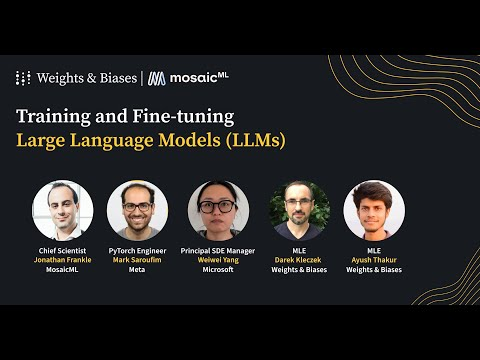

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("2QRlvKSzyVw", width=600, height=350)

## Três abordagens de uso de LLMs pré-treinados
---

<div style='align: left; text-align:center;'>
    <img src='https://substackcdn.com/image/fetch/$s_!Rtrq!,w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F3bf4e2c8-5f09-4642-b9a5-4f83e9916381_1701x853.webp' alt='Abordagens Finetuning LLMs' style="width:800px;"/>
    <span style='display:block;'>Abordagens de uso de LLMs. Veja código <a href="https://github.com/rasbt/MachineLearning-QandAI-book/blob/main/supplementary/q18-using-llms/01_classifier-finetuning/2_finetune-last-layers.ipynb"target="_blank">aqui</a>. Fonte: <a href="https://magazine.sebastianraschka.com/p/using-and-finetuning-pretrained-transformers" target="_blank">Raschka</a>.</span>
    <br/>
</div>

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from datasets import load_dataset

import numpy as np
import torch

In [ ]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "datasets"
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

In [ ]:
def set_device(on_gpu=True):
    has_mps = torch.backends.mps.is_available()
    has_cuda = torch.cuda.is_available()
    return "mps" if (has_mps and on_gpu) else "cuda" if (has_cuda and on_gpu) else "cpu"

In [ ]:
device = set_device()

In [ ]:
emotions = load_dataset("emotion")

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
print("Tokenizer input max length:", tokenizer.model_max_length)
print("Tokenizer vocabulary size:", tokenizer.vocab_size)

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding='max_length', truncation=True)

In [ ]:
emotions_tokenized = emotions.map(tokenize, batched=True, batch_size=1000)

In [ ]:
del emotions

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained("distilbert-base-uncased")
model.to(device);

In [ ]:
emotions_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"features": last_hidden_state[:,0].cpu().numpy()}

emotions_features = emotions_tokenized.map(extract_hidden_states, batched=True)

In [ ]:
X_train = np.array(emotions_features["train"]["features"])
y_train = np.array(emotions_features["train"]["label"])

X_val = np.array(emotions_features["validation"]["features"])
y_val = np.array(emotions_features["validation"]["label"])

X_test = np.array(emotions_features["test"]["features"])
y_test = np.array(emotions_features["test"]["label"])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

print("Training accuracy", clf.score(X_train, y_train))
print("Validation accuracy", clf.score(X_val, y_val))
print("Test accuracy", clf.score(X_test, y_test))

## Finetuning para Classificação ou para Instrução
---

<div style='align: left; text-align:center;'>
    <img src='https://camo.githubusercontent.com/03fd3d8084df01afb4ccbe52fab9449a55a2d1c6df17e8ff9a3f0b652112c8af/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830365f636f6d707265737365642f696e737472756374696f6e732e77656270' alt='Finetuning LLMs' style="width:800px;"/>
    <span style='display:block;'>Categorias de Finetuning de LLMs. Fonte: <a href="https://github.com/rasbt/LLMs-from-scratch/tree/main" target="_blank">Raschka</a>.</span>
    <br/>
</div>

## Tipos de *Fine-Tuning* de LLMs
---

O *fine-tuning* pode ser categorizado pela natureza da supervisão:

| Tipo | Característica | Aplicação |
| :--- | :--- | :--- |
| **Supervisionado** | Utiliza dados rotulados adaptados à tarefa alvo. | Classificação de texto, tarefas de Geração de Texto específicas. |
| **Não Supervisionado** | Expõe o LLM a um grande *corpus* de texto não rotulado do domínio alvo. | Refino da compreensão linguística em novos domínios (ex: área jurídica ou médica). |
| **Por Instrução** | Utiliza instruções em linguagem natural (*Prompt Engineering*) para treinar o modelo a seguir comandos. | Criação de assistentes conversacionais especializados. |

## Pipeline Geral de Finetuning de LLMs
---

<center>

<table style="width:100%;border:none;">
<tr>
<td style="vertical-align:middle;text-align:left;border:none;width:45%;">

*   **Estágio 1: Preparação do Conjunto de Dados**
    *   Limpeza, formatação e divisão do conjunto de dados para corresponder à tarefa alvo.
*   **Estágio 2: Inicialização do Modelo**
    *   Consiste em configurar os parâmetros iniciais e as configurações do LLM.
*   **Estágio 3: Configuração do Ambiente de Treinamento**
    *   Configuração de *hardware* e *software*, hiperparâmetros e arquitetura do modelo.
*   **Estágio 4: Ajuste Fino Parcial ou Completo**
    *   É o processo de atualização dos parâmetros do LLM utilizando o *dataset* específico da tarefa.
</td>
<td style="vertical-align:middle;text-align:center;border:none;width:45%;">
<img src='https://arxiv.org/html/2408.13296v3/extracted/5964107/images/Fine-tuning_LLM_process.jpg' alt='Finetuning LLMs: Pipeline' style="width:500px;"/>
<span style='display:block;'>Seven Stage Fine-Tuning Pipeline for LLM. Fonte: <a href="https://arxiv.org/html/2408.13296v3#Ch2" target="_blank">Parthasarathy et al.</a></span>
</td>
</tr>
</table>

</center>

## Pipeline Geral de Finetuning de LLMs (cont.)
---

<center>

<table style="width:100%;border:none;">
<tr>
<td style="vertical-align:middle;text-align:left;border:none;width:45%;">
    
*   **Estágio 5: Avaliação e Validação**
    *   Métricas como **entropia cruzada** e o monitoramento de curvas de perda (*loss curves*).
*   **Estágio 6: Implantação**
    * Execução eficiente em plataformas de *hardware* ou *software* designadas e a implementação de medidas de segurança e sistemas de monitoramento.
*   **Estágio 7: Monitoramento e Manutenção**
    *   Rastreamento contínuo do desempenho, atualização do modelo conforme necessário para se adaptar a novos dados ou requisitos em constante mudança.

</td>
<td style="vertical-align:middle;text-align:center;border:none;width:45%;">
<img src='https://arxiv.org/html/2408.13296v3/extracted/5964107/images/Fine-tuning_LLM_process.jpg' alt='Finetuning LLMs: Pipeline' style="width:500px;"/>
<span style='display:block;'>Seven Stage Fine-Tuning Pipeline for LLM. Fonte: <a href="https://arxiv.org/html/2408.13296v3#Ch2" target="_blank">Parthasarathy et al.</a></span>
</td>
</tr>
</table>

</center>

## Desafios de Escalabilidade e Recursos
---

O *fine-tuning* de LLMs apresenta barreiras significativas:

*   **Requisitos de Memória:** O *fine-tuning* exige memória substancialmente maior do que a inferência. Por exemplo, o LLaMA 2 (7B parâmetros) em FP32 exige aproximadamente **112 GB de VRAM** para o *fine-tuning*, limitando a acessibilidade para a maioria dos hardwares de consumo.
*   **Otimização de Recursos:** A implantação eficiente requer técnicas como *Quantized LLMs* (quantização de modelos), que representam parâmetros com menos bits (ex: 8-bit ou 4-bit) para reduzir o tamanho do modelo e otimizar a inferência.

## Considerações Éticas
---
O *fine-tuning* pode exacerbar questões éticas:
*   **Vieses (*Bias*) e Justiça (*Fairness*):** *Datasets* de *fine-tuning* podem conter vieses que são transferidos e amplificados no modelo. É crucial usar dados diversos e representativos.
*   **Privacidade:** O uso de dados sensíveis exige técnicas de preservação, como a **Privacidade Diferencial** e o **Aprendizado Federado** (*Federated Learning*).
*   **Responsabilidade e Transparência:** Dada a capacidade do *fine-tuning* de alterar o comportamento do LLM, é fundamental documentar detalhadamente o processo, o *dataset* e o impacto, utilizando *frameworks* como *Model Cards* ou *AI FactSheets*.

## Demo: Finetuning de um modelo GPT-2
---

- Tarefa: Classificação de Spam.
- Dataset: SMS Spam Collection (público)

### Preparando o dataset
---

In [ ]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


In [ ]:
def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Download
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzip
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Extensão .tsv
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [ ]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [ ]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]

    # Seleciona amostras não-spam
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # Combina dados das duas classes
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [ ]:
def random_split(df, train_frac, validation_frac):
    # Embaralha o DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True) # frac=1 means the entire dataset

    # Calcula índices de treino e validação
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Divide os dados
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end] # to get an estimate during training how well the model performs
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

### Criando Data Loaders
---

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [ ]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):  # retrieves one example
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [ ]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [ ]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [ ]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [ ]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


### Inicializando o Modelo com Parâmetros Pré-treinados
---

In [ ]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [ ]:
assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [ ]:
import os
import requests
import json
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
import tensorflow as tf

In [ ]:
def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params

In [ ]:
def download_file(url, destination):
    # Send a GET request to download the file in streaming mode
    response = requests.get(url, stream=True)

    # Get the total file size from headers, defaulting to 0 if not present
    file_size = int(response.headers.get("content-length", 0))

    # Check if file exists and has the same size
    if os.path.exists(destination):
        file_size_local = os.path.getsize(destination)
        if file_size == file_size_local:
            print(f"File already exists and is up-to-date: {destination}")
            return

    # Define the block size for reading the file
    block_size = 1024  # 1 Kilobyte

    # Initialize the progress bar with total file size
    progress_bar_description = url.split("/")[-1]  # Extract filename from URL
    with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
        # Open the destination file in binary write mode
        with open(destination, "wb") as file:
            # Iterate over the file data in chunks
            for chunk in response.iter_content(block_size):
                progress_bar.update(len(chunk))  # Update progress bar
                file.write(chunk)  # Write the chunk to the file

In [ ]:
def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from llmdefinitions import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [ ]:
from llmdefinitions import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [ ]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
    " Answer with 'yes' or 'no'."
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' Answer with 'yes' or 'no'. Answer with 'yes' or 'no'. Answer with 'yes' or 'no'. Answer with 'yes'


### Adicionando Camada de Classificação (Classification Head)
---

Substituiremos a camada de saída original – que mapeava a representação oculta para um vocabulário de 50 257 tokens – por uma camada de saída mais compacta que projeta esses mesmos 768 unidades ocultas em apenas duas classes: 0 (“não spam”) e 1 (“spam”).

In [ ]:
# Congelamos o modelo, isto é, tornamos todas as camadas não treináveis.
for param in model.parameters():
    param.requires_grad = False

Em seguida, substituímos a camada de saída (`model.out_head`), que originalmente mapeia as entradas da camada para 50 257 dimensões (o tamanho do vocabulário). Como o modelo será fine‑tuned para classificação binária, podemos trocar a camada de saída conforme mostrado abaixo; tal nova camada será treinável por padrão. Observe que utilizamos `BASE_CONFIG["emb_dim"]` (que equivale a 768 no modelo “gpt2-small (124M)”) para manter o trecho de código mais genérico.

In [ ]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

Tecnicamente, basta treinar apenas a camada de saída. Contudo, o fine‑tuning de camadas adicionais pode melhorar significativamente o desempenho preditivo do modelo. Portanto, também tornamos treináveis o último bloco transformador e o módulo final `LayerNorm` que conecta esse bloco ao layer de saída.

In [ ]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [ ]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [ ]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


Ao discutir o mecanismo de atenção – que conecta cada token de entrada a todos os demais tokens de entrada – introduzimos a máscara causal de atenção utilizada em modelos do tipo GPT; tal máscara causal permite que um token atual atenda apenas às posições atuais e anteriores. Com base nesse mecanismo causal, o quarto (último) token contém a maior quantidade de informação dentre todos os tokens, pois é o único que incorpora dados sobre todos os demais tokens.

Assim, nosso foco recai especificamente sobre esse último token, que será fine‑tuned para a tarefa de classificação de spam:

In [ ]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


### Calculando Loss e Accuracy
---

Convertemos os valores de saída (logits) em escores de probabilidade por meio da função `softmax` e, em seguida, obtivemos a posição do índice correspondente ao maior valor de probabilidade utilizando a função `argmax`.

In [ ]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


O código retorna 1, o que indica que o modelo prevê que o texto de entrada seja “spam”. Observe que a aplicação da função `softmax` é opcional neste ponto, pois os valores de saída maiores correspondem aos maiores escores de probabilidade. Consequentemente, podemos simplificar o trecho de código conforme abaixo, omitindo a chamada ao `softmax`.

In [ ]:
logits = outputs[:, -1, :]
label = torch.argmax(logits) # Pula Softmax
print("Class label:", label.item())

Class label: 1


Para calcular a acurácia de classificação, podemos aplicar o código de predição baseado em `argmax`, descrito anteriormente, a todos os exemplos de um conjunto de dados e determinar a fração de previsões corretas da seguinte forma:

In [ ]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


A acurácia de classificação não é uma função diferenciável. Portanto, em vez disso, minimizamos a perda de entropia cruzada como um proxy para maximizar essa acurácia. Nos concentramos apenas na otimização do último token (`model(input_batch)[:, -1, :]`) ao invés de todos os tokens (`model(input_batch)`).

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token only
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


### Finetuning do Modelo usando Dados Rotulados
---


In [ ]:
def train_classifier_simple(model, train_loader, val_loader,
                            optimizer, device, num_epochs,
                            eval_freq, eval_iter, tokenizer):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous epoch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 60.93 m

In [ ]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

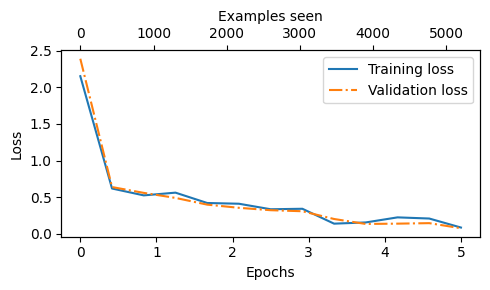

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

Como se observa pelo declive acentuado, o modelo está aprendendo eficazmente a partir dos dados de treinamento, sem qualquer indicação perceptível de overfitting; isto é, não há lacuna notável entre as perdas do conjunto de treinamento e da validação.

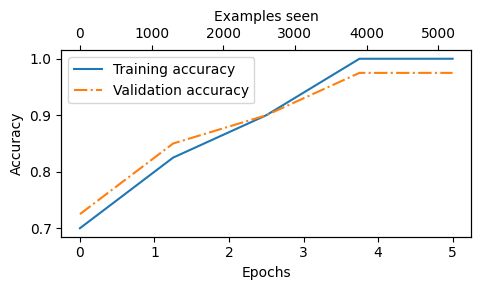

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

Tanto a acurácia de treinamento (linha sólida) quanto a acurácia de validação (linha tracejada) aumentam substancialmente nas primeiras épocas e, em seguida, atingem um platô, obtendo pontuações quase perfeitas de 1,0. A proximidade estreita das duas curvas ao longo das épocas indica que o modelo não sofre um overfitting significativo dos dados de treinamento.

Com base no gráfico de acurácia acima, observamos que o modelo alcança uma acurácia relativamente alta tanto em treinamento quanto em validação após as 4ª e 5ª épocas. Contudo, é importante lembrar que especificamos `eval_iter=5` na função de treino anterior, o que implica que apenas estimamos os desempenhos nos conjuntos de treinamento e validação.

In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")
# Training accuracy: 97.21%
# Validation accuracy: 97.32%
# Test accuracy: 95.67%

Observamos que os desempenhos nos conjuntos de treinamento e teste são quase idênticos. Contudo, considerando o desempenho um pouco inferior no conjunto de teste, verificamos que o modelo apresenta overfitting dos dados de treinamento em uma escala muito pequena, bem como dos dados de validação utilizados para ajustar alguns hiper‑parâmetros, como a taxa de aprendizado. Tal situação é normal e essa diferença pode ser ainda mais reduzida aumentando a taxa de dropout (`drop_rate`) ou o parâmetro `weight_decay` na configuração do otimizador.

### Usando o LLM como um classificador de Spam
---
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-4.webp" width=500px>

In [ ]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    # Truncamento
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Inferência
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [ ]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))
# Resposta: Spam

In [ ]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))
# Resposta: Not Spam

### Salva o Modelo
---

In [ ]:
torch.save(model.state_dict(), "review_classifier.pth")

### Carrega o Modelo
---

In [ ]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

## Leitura Recomendada

- [Using and Finetuning Pretrained Transformers](https://magazine.sebastianraschka.com/p/using-and-finetuning-pretrained-transformers)
- [The Ultimate Guide to Fine-Tuning LLMs from Basics to Breakthroughs](https://arxiv.org/abs/2408.13296)